# Text Encoding Model

In [1]:
import fastai
print(fastai.__version__) # version check

2.7.15


In [2]:
from fastai.text.all import *

In [3]:
# Load the data
path = Path('data/txt/train')

In [4]:
batch_size  = 64 # default value for fastai v2 

In [5]:
# Create a DataBlock for language modeling
dblock = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True), # Define the block as TextBlock for LM
    get_items=get_text_files,                      # Get the text files
    splitter=FuncSplitter(lambda x: False)         # Do not split the data into train/validation sets
)

# Create DataLoaders
dls = dblock.dataloaders(path, bs=batch_size)


In [6]:
# Check the DataLoader
dls.show_batch(max_n=3)

In [7]:
# Create a learner for language modeling using AWD_LSTM architecture
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3)

In [8]:
# checking
learn.predict('bird is black', n_words=30, temperature=0.75)

'bird is black - headed - red - headed , grey - headed , black - headed , black - and - white , and white - headed . The primary is'

In [12]:
encoder = learn.model[0]

In [10]:
# Verify DataLoader
print(f"Number of batches: {len(learn.dls.train)}")

Number of batches: 39


In [13]:
encoder.eval()
with torch.no_grad():
    for xb,yb in progress_bar(learn.dls.train):
        print(xb.shape)
        print(encoder(xb)[0][-1].shape)
        break

torch.Size([64, 72])
torch.Size([400])


In [14]:
# saving encoder
learn.save_encoder('encode')

## check the below cell

In [19]:
def get_multibatch_encoder(bptt, max_len, model):
    # Create RNNCore equivalent
    return model[0].encoder  # Assuming AWD_LSTM has an 'encoder' attribute

# Define parameters for MultiBatchEncoder
bptt = 72
max_len = 20 * bptt

# Get MultiBatchEncoder
encoder = get_multibatch_encoder(bptt, max_len, learn.model)

In [20]:
t=encoder(xb)

In [21]:
# Print shapes for debugging
print(f"t[0] shape: {t[0].shape}")
print(f"t[0][-1] shape: {t[0][-1].shape}")

t[0] shape: torch.Size([72, 400])
t[0][-1] shape: torch.Size([400])


## Classifier

In [22]:
def fn2class(fn):
    fields = os.path.basename(fn).split('_')
    label = '_'.join(fields[:-3])
    print(f"Filename: {fn}, Label: {label}")  # Debugging line
    return label

In [23]:
# Define the path to the data
path = Path('data/txt/train')

# Create a DataBlock for text classification
datablock = DataBlock(
    blocks=(TextBlock.from_folder(path), CategoryBlock),  # Define the blocks as TextBlock and CategoryBlock
    get_items=get_text_files,                            # Get the text files
    splitter=RandomSplitter(valid_pct=0.2),              # Randomly split the data into train/validation sets
    get_y=fn2class                                       # Use fn2class to get the labels
)

# Create DataLoaders
data_class = datablock.dataloaders(path, bs=32)  # Updated to use standard naming convention

# Show batch for debugging
data_class.show_batch()


Filename: data/txt/train/Cerulean_Warbler_0071_163201_3.txt, Label: Cerulean_Warbler
Filename: data/txt/train/Green_Tailed_Towhee_0060_154820_1.txt, Label: Green_Tailed_Towhee
Filename: data/txt/train/Mourning_Warbler_0031_166494_2.txt, Label: Mourning_Warbler
Filename: data/txt/train/Ring_Billed_Gull_0003_51480_1.txt, Label: Ring_Billed_Gull
Filename: data/txt/train/Carolina_Wren_0032_186566_0.txt, Label: Carolina_Wren
Filename: data/txt/train/Bobolink_0074_9311_0.txt, Label: Bobolink
Filename: data/txt/train/Ring_Billed_Gull_0039_50191_4.txt, Label: Ring_Billed_Gull
Filename: data/txt/train/Fish_Crow_0080_25861_3.txt, Label: Fish_Crow
Filename: data/txt/train/Elegant_Tern_0072_150911_2.txt, Label: Elegant_Tern
Filename: data/txt/train/Gray_Catbird_0031_21635_0.txt, Label: Gray_Catbird
Filename: data/txt/train/Cliff_Swallow_0100_133665_2.txt, Label: Cliff_Swallow
Filename: data/txt/train/Cerulean_Warbler_0071_163201_1.txt, Label: Cerulean_Warbler
Filename: data/txt/train/Bobolink_0065

In [24]:
# Accessing class labels
class_labels = data_class.categorize.vocab

# Accessing number of classes
num_classes = data_class.c

print(f"Class Labels: {class_labels}")
print(f"Number of Classes: {num_classes}")


Class Labels: ['American_Redstart', 'Blue_Headed_Vireo', 'Bobolink', 'Bronzed_Cowbird', 'Cactus_Wren', 'Cape_Glossy_Starling', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern', 'Cerulean_Warbler', 'Cliff_Swallow', 'Eastern_Towhee', 'Elegant_Tern', 'Evening_Grosbeak', 'Fish_Crow', 'Florida_Jay', 'Gadwall', 'Gray_Catbird', 'Green_Kingfisher', 'Green_Tailed_Towhee', 'Hooded_Merganser', 'Ivory_Gull', 'Laysan_Albatross', 'Loggerhead_Shrike', 'Magnolia_Warbler', 'Mourning_Warbler', 'Northern_Fulmar', 'Orchard_Oriole', 'Prothonotary_Warbler', 'Ring_Billed_Gull', 'Ringed_Kingfisher', 'Ruby_Throated_Hummingbird', 'Scissor_Tailed_Flycatcher']
Number of Classes: 33


In [25]:
data_class.loss_func

FlattenedLoss of CrossEntropyLoss()

In [26]:
learn_classifier = text_classifier_learner(data_class, AWD_LSTM, loss_func=LabelSmoothingCrossEntropy())

Filename: data/txt/train/Gray_Catbird_0053_20694_0.txt, Label: Gray_Catbird
Filename: data/txt/train/Cliff_Swallow_0039_133645_0.txt, Label: Cliff_Swallow
Filename: data/txt/train/Cardinal_0084_17576_0.txt, Label: Cardinal
Filename: data/txt/train/Cardinal_0079_19044_0.txt, Label: Cardinal
Filename: data/txt/train/Green_Tailed_Towhee_0051_154768_2.txt, Label: Green_Tailed_Towhee
Filename: data/txt/train/Magnolia_Warbler_0020_166211_1.txt, Label: Magnolia_Warbler
Filename: data/txt/train/American_Redstart_0054_103543_3.txt, Label: American_Redstart
Filename: data/txt/train/Ring_Billed_Gull_0057_51315_4.txt, Label: Ring_Billed_Gull
Filename: data/txt/train/Laysan_Albatross_0056_500_1.txt, Label: Laysan_Albatross
Filename: data/txt/train/Hooded_Merganser_0024_796779_3.txt, Label: Hooded_Merganser
Filename: data/txt/train/Cape_Glossy_Starling_0019_129407_1.txt, Label: Cape_Glossy_Starling
Filename: data/txt/train/Blue_Headed_Vireo_0088_156416_1.txt, Label: Blue_Headed_Vireo
Filename: data/

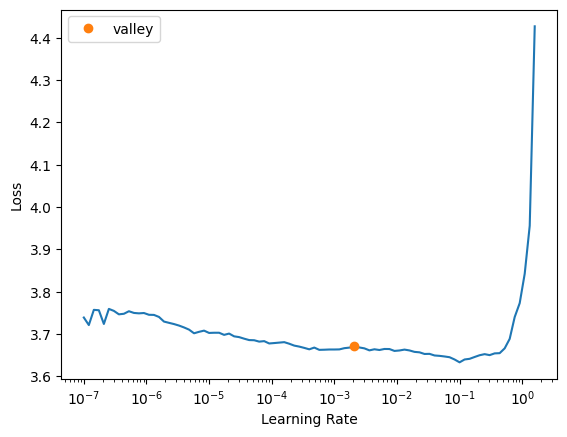

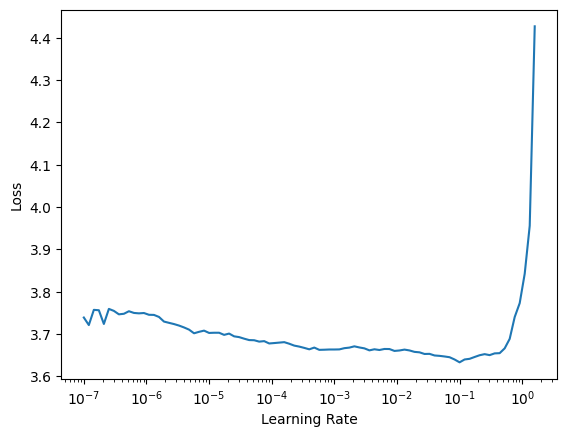

In [27]:
learn_classifier.lr_find()  # Find optimal learning rate
learn_classifier.recorder.plot_lr_find()  # Plot learning rate finder results

In [28]:
learn_classifier.fit_one_cycle(n_epoch=5, lr_max=1e-1, wd=0.1)
#default value of moms (0.95, 0.85)

Filename: data/txt/train/Gray_Catbird_0053_20694_0.txt, Label: Gray_Catbird
Filename: data/txt/train/Cardinal_0084_17576_3.txt, Label: Cardinal
Filename: data/txt/train/Cardinal_0079_19044_0.txt, Label: Cardinal
Filename: data/txt/train/Eastern_Towhee_0015_22275_0.txt, Label: Eastern_Towhee
Filename: data/txt/train/Ringed_Kingfisher_0057_72812_0.txt, Label: Ringed_Kingfisher
Filename: data/txt/train/Cactus_Wren_0085_185515_3.txt, Label: Cactus_Wren
Filename: data/txt/train/Blue_Headed_Vireo_0002_156241_3.txt, Label: Blue_Headed_Vireo
Filename: data/txt/train/Florida_Jay_0011_64920_4.txt, Label: Florida_Jay
Filename: data/txt/train/Green_Kingfisher_0032_71050_2.txt, Label: Green_Kingfisher
Filename: data/txt/train/Eastern_Towhee_0105_22675_4.txt, Label: Eastern_Towhee
Filename: data/txt/train/Florida_Jay_0011_64920_1.txt, Label: Florida_Jay
Filename: data/txt/train/Green_Kingfisher_0027_71048_0.txt, Label: Green_Kingfisher
Filename: data/txt/train/Cardinal_0074_18339_2.txt, Label: Cardi

In [29]:
encoder = learn_classifier.model[0].module

In [30]:
_ = encoder.eval()

In [31]:
fns = get_files('data/txt/train/', extensions=['.txt'])

In [32]:
len(fns), fns[0]

(9776, Path('data/txt/train/Bronzed_Cowbird_0011_24138_0.txt'))

In [37]:
warnings.filterwarnings('ignore')

In [46]:
embedding = {}
with torch.no_grad():
    for fn in progress_bar(fns):
        with open(fn, 'r') as f: txt = f.read()
        dl = learn_classifier.dls.test_dl([txt])
        xb = dl.one_batch()[0]
        embedding[os.path.basename(fn)] = encoder(xb)[0][-1].view(400,1,1) 

In [47]:
len(embedding)

9776

In [48]:
for k in embedding:
    embedding[k] = embedding[k].cpu()

In [49]:
torch.save(embedding, 'embedding.pkl')